# Processing GEM2 and magnaprobe data - AeN Q1 P5

**Adam Steer**

From Magnaprobe and GEM2 measurements we get snow depth at about 1-2m along track resolotion, and combined snow + ice depth at some unknown resolution.

From these datasets, we need to generate snow depth (done!), ice thickness, draft and freeboard.

For ice thickness, draft and freeboard we rely on some assumptions about hydrostatic equilibrium and density of snow and ice. Using those, we model freeboard and draft using snow depths from the magnaprobe and combined snow and ice thickness from the GEM2 as constraints.

This notebook uses the approach:

- collect drift-corrected magnaprobe data into a set of point geometries
- collect drift-corrected GEM2 data into a set of point geometries
- test each magnaprobe point and find GEM2 data within 2.5 m radius (5m diameter)
- collect the median of GEM2 points found in that radius
- subtract magnaprobe snowdepth from median of GEM2 points
- use median GEM2 data, magnaprobe snow depth, and snow/ice density observations to compute ice thickness, draft and freeboard

This will result in a lot of overlapping data - for example two consecutive magnaprobe points are very likely to have overlap in their region where GEM2 data are collected. Given that GEM2 has a footprint of approximately 4 m diamter, this simple relfects the reality of how the measurements are collected. If needed, spatial filtering can be done later.


In [1]:
## import all the things we need

import os

import numpy as np

from scipy import stats

import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt.rcParams['font.size'] =18
inches = 2.51

from shapely import geometry

import pyproj

# array functions, used to generate moving standard deviations
import bottleneck as bn


In [2]:
# declare a function to compute freeboard
def find_fi(zi, zs, dwater, dice, dsnow):
    
    #derived by Claire Trenham, CSIRO, and Adam Steer.
    fi = (((dwater - dice) * zi) - dsnow * zs) / dwater
    
    return fi

# A stats printing function
def printstats(inputdata):
    print("number of observations: {}".format(len(inputdata)))
    print("min: {}".format(np.nanmin(inputdata)))
    print("max: {}".format(np.nanmax(inputdata)))
    print("mean: {}".format(np.nanmean(inputdata)))
    print("median: {}".format(np.nanmedian(inputdata)))
    print("standard deviation: {}".format(np.nanstd(inputdata)))
    print("skewness: {}".format(stats.skew(inputdata)))
    

In [3]:
## set some phsyical properties, these are used to compute sea ice freeboard

# density of seawater
d_water = 1027

# density of sea ice
d_ice = 915

# density of snow
d_snow = 350

### Start loading MP data

In [6]:
mp_data = pd.read_csv("/mnt/documents/Q1/P5-12032021/magnaprobe/MPdata-driftcorrected-datefixed.csv",
                      skiprows = 10)

In [56]:
mp_data

timestamp       easting       northing  snowdepth
0     12-03-2021T13:55:16.16  1.013252e+06 -194850.405631    -0.0001
1     12-03-2021T13:55:18.81  1.013251e+06 -194850.820286     1.2100
2     12-03-2021T13:55:21.14  1.013252e+06 -194850.866244    -0.0001
3     12-03-2021T13:55:23.49  1.013252e+06 -194851.321181     1.2100
4     12-03-2021T13:56:04.48  1.013252e+06 -194847.729264     0.1305
...                      ...           ...            ...        ...
1574  12-03-2021T15:17:01.75  1.013230e+06 -194843.778249     0.1253
1575  12-03-2021T15:17:22.73  1.013228e+06 -194845.203024    -0.0001
1576  12-03-2021T15:17:28.97  1.013228e+06 -194844.216000     1.2100
1577  12-03-2021T15:17:32.62  1.013229e+06 -194844.070459    -0.0001
1578  12-03-2021T15:17:37.72  1.013228e+06 -194843.217885     1.2100

[1579 rows x 4 columns]

In [58]:
mp_data = mp_data.loc[(mp_data["snowdepth"] > 0) & (mp_data["snowdepth"] < 1.2)]

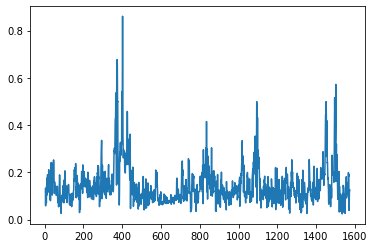

In [59]:
plt.plot(mp_data["snowdepth"])

In [60]:
# generate a list of tuple coordinate pairs
xypairs = list(zip(mp_data["easting"].values, mp_data["northing"].values))

In [61]:
xypairs[0]

(1013252.4380902929, -194847.7292642683)

In [62]:
# make geometries from each point
mp_points = []

for pair in xypairs:
    mp_points.append(geometry.Point(pair[0], pair[1]))

In [63]:
# make buffered points, with 24 sided 'circles'

mp_buffers = []
for point in mp_points:
    mp_buffers.append(point.buffer(5, resolution=36))

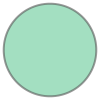

In [64]:
mp_buffers[0]

### Check distance between magnaprobe samples

get difference between array elements in X and Y coordinates, do some Pythagoras to get an idea of the magnaprobe observation step size.

This gives an approximate along-track ground sampling distance, useful for setting filtering windows later

In [65]:
stepX = np.diff(mp_data["easting"].values-5)
stepY = np.diff(mp_data["northing"].values)
mp_point2point = np.sqrt(stepX**2 + stepY**2)

In [66]:
printstats(mp_point2point)

number of observations: 1556
min: 0.011975709544566827
max: 24.20829948505995
mean: 0.9668671069180885
median: 0.8873926412284147
standard deviation: 0.791852178997644
skewness: 17.026993107231352


### Read and geometry-ify GEM2 data

In [67]:
gem2_data = pd.read_csv("/mnt/documents/Q1/P5-12032021/GEM2/GEM2data-driftcorrected.csv",
                      skiprows = 10)

In [68]:
gem2_data[0:5]

time   record_id       easting       northing   xc  \
0  2021-03-12T13:56:58.453125           9  1.013258e+06 -194846.276417  0.0   
1  2021-03-12T13:56:58.546875          10  1.013258e+06 -194846.296296  0.0   
2  2021-03-12T13:56:58.640625          11  1.013258e+06 -194846.317920  0.0   
3  2021-03-12T13:56:58.750000          12  1.013258e+06 -194846.341451  0.0   
4  2021-03-12T13:56:58.843750          13  1.013258e+06 -194846.361329  0.0   

    yc  f450Hz_hcp_i   f450Hz_hcp_q   f1530Hz_hcp_i   f1530Hz_hcp_q  \
0  0.0           nan          0.877           0.788           0.889   
1  0.0           nan          0.862           0.774           0.892   
2  0.0           nan          0.849           0.782           0.887   
3  0.0           nan          0.840           0.829           0.880   
4  0.0           nan          0.847           0.826           0.876   

    f5310Hz_hcp_i   f5310Hz_hcp_q   f18330Hz_hcp_i   f18330Hz_hcp_q  \
0           0.884           0.872            0.884            0.876   
1           0.877           0.874            0.883            0.877   
2           0.872           0.875            0.885            0.875   
3           0.861           0.876            0.885            0.876   
4           0.856           0.879            0.882            0.875   

    f63030Hz_hcp_i  f63030Hz_hcp_q  
0            0.897             nan  
1            0.897             nan  
2            0.897             nan  
3            0.898             nan  
4            0.897             nan

In [69]:
gem2_data.keys()

Index(['time', ' record_id', 'easting', 'northing', ' xc', ' yc',
       ' f450Hz_hcp_i', ' f450Hz_hcp_q', ' f1530Hz_hcp_i', ' f1530Hz_hcp_q',
       ' f5310Hz_hcp_i', ' f5310Hz_hcp_q', ' f18330Hz_hcp_i',
       ' f18330Hz_hcp_q', ' f63030Hz_hcp_i', ' f63030Hz_hcp_q'],
      dtype='object')

### check distance between GEM2 samples

This gives an approximate along-track ground sampling distance, useful for setting filtering windows later

In [70]:
stepX = np.diff(gem2_data["easting"].values)
stepY = np.diff(gem2_data["northing"].values)

gem2_point2point = np.sqrt(stepX**2 + stepY**2)

In [71]:
printstats(gem2_point2point)

number of observations: 27359
min: 9.882745337747018e-05
max: 7.974013119916488
mean: 0.05219018587977914
median: 0.054877483465602415
standard deviation: 0.08474519734112583
skewness: 57.89482510666573


### Check that the coordinates line up!

Added a -5m translation to Magnaprobe data eastings so it lines up. Northing seems OK

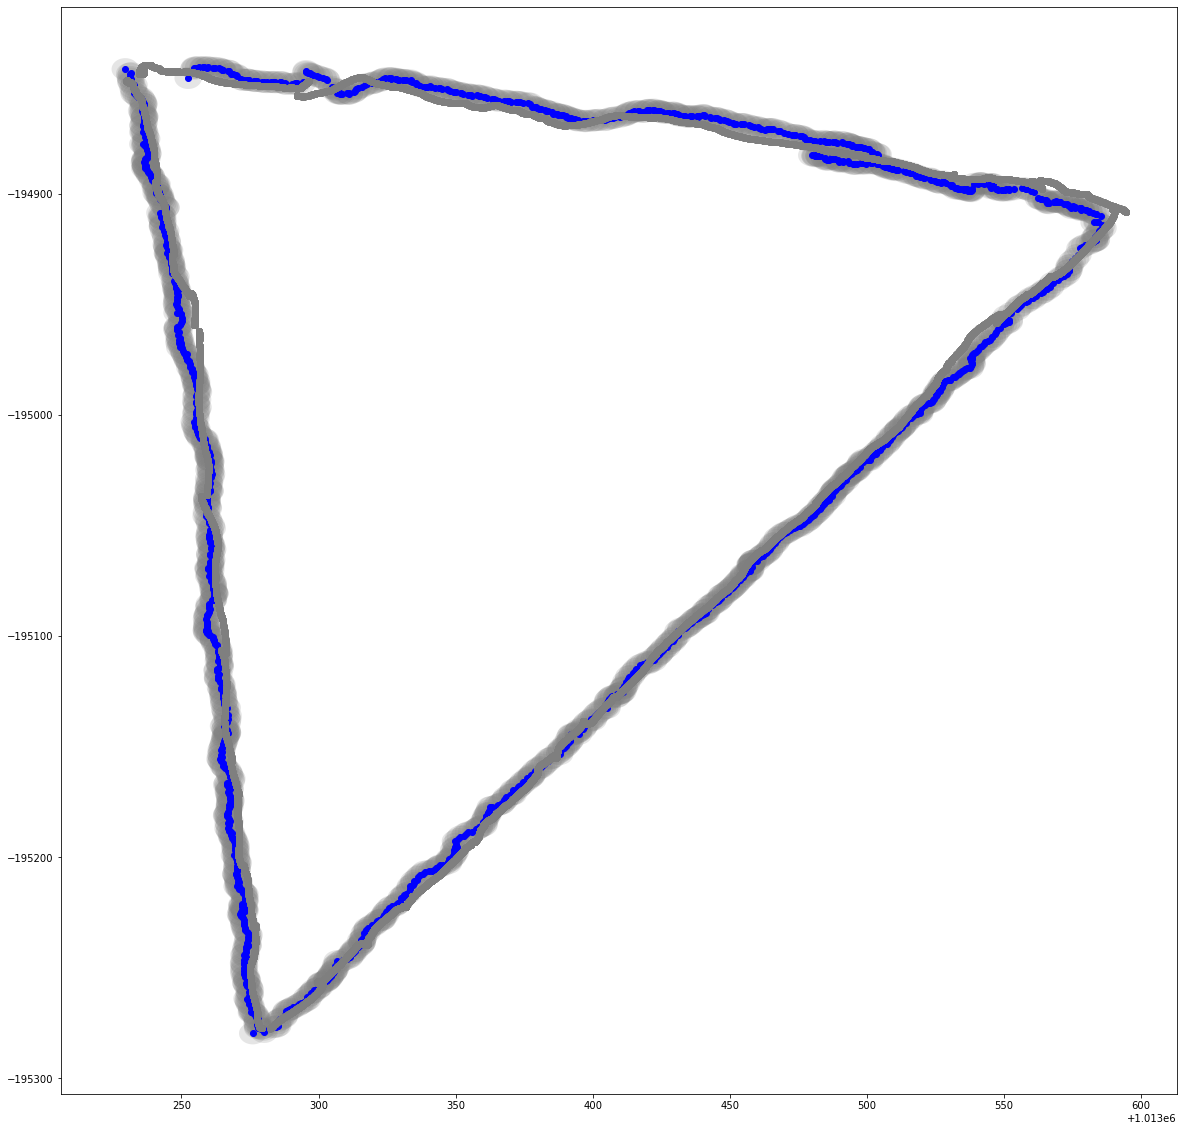

In [72]:
fig = plt.figure(figsize=(20,20))

for dot in mp_buffers:    
    xs, ys = dot.boundary.xy    
    plt.fill(xs, ys, alpha=0.2, fc='grey', ec='none')
    
plt.scatter(mp_data["easting"].values, mp_data["northing"].values, c="Blue")
plt.scatter(gem2_data["easting"].values-22, gem2_data["northing"].values+3)

In [73]:
len(gem2_data["easting"].values)

27360

In [74]:
gem2_xypairs = list(zip(gem2_data["easting"].values-22, gem2_data["northing"].values+3))

In [75]:
# make geometries from each point
gem2_points = []

for pair in gem2_xypairs:
    gem2_points.append(geometry.Point(pair[0], pair[1]))

In [76]:
len(gem2_points)

27360

## Select GEM2 data points to use

- find GEM2 points within the buffer from MP points
- collect GEM2 observations matching those points
- compute the median of GEM2 observations
- assemble an array of MP and matching median GEM2 observations

In [77]:
mp_ind = 0
gem2_ind = 0
bufferpoints = []
collected_points = []

# iterate over MP buffers
for buffer in mp_buffers:
    #print("buffer {}".format(mp_ind))
    #then over gem2 points
    for thispoint in gem2_points:
        
        #if the buffer contains the point
        if buffer.contains(thispoint):
            
            #capture the index of each point the buffer contains
            bufferpoints.append(gem2_ind)
        
        gem2_ind += 1
    gem2_ind = 0
    collected_points.append([mp_ind, bufferpoints])
    bufferpoints = []
    mp_ind += 1

In [82]:
gem2_data[" f5310Hz_hcp_i"][np.array(collected_points[4][1])]

790    0.835
791    0.845
792    0.838
793    0.813
794    0.801
       ...  
894    0.784
895    0.783
896    0.763
897    0.757
898    0.764
Name:  f5310Hz_hcp_i, Length: 109, dtype: float64

In [83]:
np.median(gem2_data[" f5310Hz_hcp_i"][np.array(collected_points[4][1])])

0.767

In [84]:
# a little check

np.median(gem2_data[" f1530Hz_hcp_i"][np.array(collected_points[4][1])])


0.737

In [85]:
#generate a list of MP data indexes and GEM2 median measurements
median_gem2 = []

for datapoint in collected_points:
    if len(datapoint[1]) > 0:
        thismedian = np.median(gem2_data[" f5310Hz_hcp_i"][datapoint[1]])

    else:
        thismedian = np.nan
        
    the_array = [datapoint[0], thismedian]
    median_gem2.append(the_array)

In [86]:
median_gem2[0:5]

[[0, 0.78], [1, 0.773], [2, 0.773], [3, 0.771], [4, 0.767]]

In [87]:
mp_inds = [pair[0] for pair in median_gem2]
mp_inds[0:5]

[0, 1, 2, 3, 4]

In [88]:
gem2_zi = [pair[1] for pair in median_gem2]

In [89]:
len(mp_inds)

1557

In [90]:
len(mp_data["snowdepth"])

1557

In [91]:
zi = gem2_zi - mp_data["snowdepth"].values

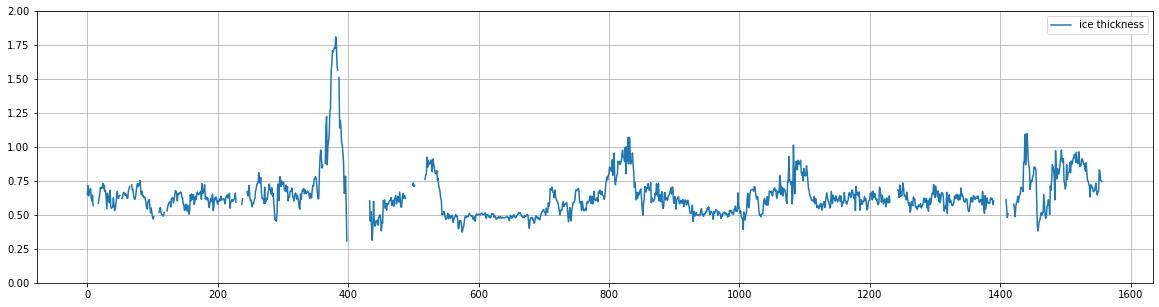

In [95]:
# quick ice thickness plot.
# note any negative values likely come from a data point in the Magnaprobe dataset which should be cleaned out 

fig = plt.figure(figsize=(20,5))

plt.plot(zi, label = "ice thickness")
plt.ylim(0, 2)
plt.legend()
plt.grid()

In [96]:
# show some basic stats
printstats(zi[5:-5])

number of observations: 1547
min: 0.30800000000000005
max: 1.80954
mean: 0.6385461500353857
median: 0.6154
standard deviation: 0.15764558455546585
skewness: nan


#### Ice freeboard

In [97]:
#(zi, zs, dwater, dice, dsnow)
freeboards = find_fi(zi,mp_data["snowdepth"].values, 1027, 915, 315)

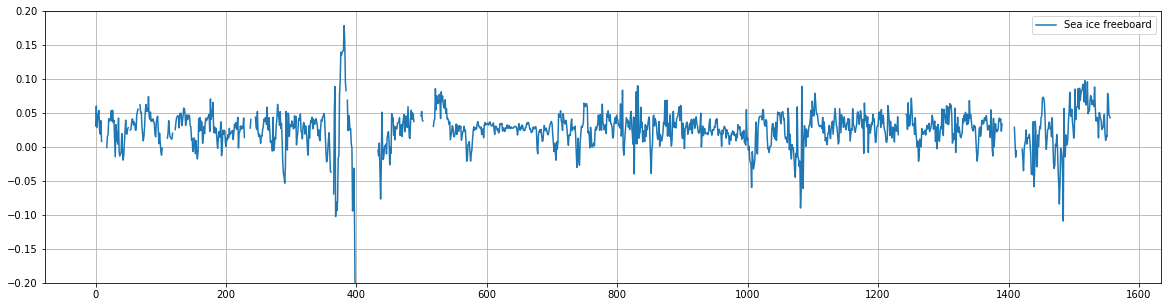

In [99]:
fig = plt.figure(figsize=(20,5))

plt.plot(freeboards, label = "Sea ice freeboard")
plt.ylim(-0.2, 0.2)
plt.legend()
plt.grid()

In [100]:
printstats(freeboards)

number of observations: 1557
min: -0.23049561830574486
max: 0.17848936708860758
mean: 0.0263179679503716
median: 0.02816835443037973
standard deviation: 0.027124624896437095
skewness: nan


### ice draft

In [101]:
drafts = freeboards - zi

(-2.0, 0.0)

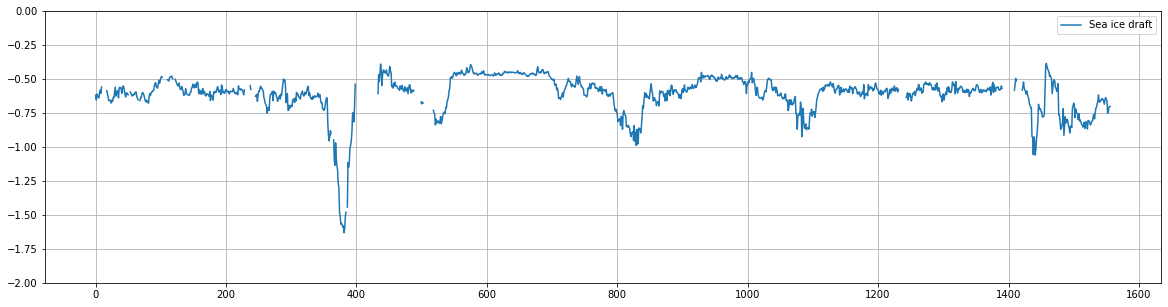

In [104]:
fig = plt.figure(figsize=(20,5))

plt.plot(drafts, label = "Sea ice draft")
plt.legend()
plt.grid()
plt.ylim(-2,0)

In [105]:
printstats(drafts)

number of observations: 1557
min: -1.6310506329113923
max: -0.38552336903602735
mean: -0.6128387572780192
median: -0.588636806231743
standard deviation: 0.14673032916829196
skewness: nan


#### Sea ice surface elevation

What we see at the top - snow depth plus freeboard

In [106]:
elevation = freeboards + mp_data["snowdepth"].values

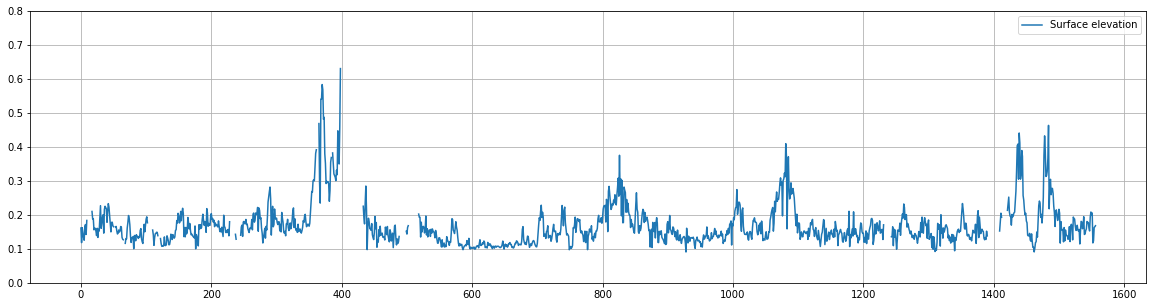

In [110]:
fig = plt.figure(figsize=(20,5))

plt.plot(elevation, label = "Surface elevation")
plt.ylim(0, 0.8)
plt.legend()
plt.grid()

#### snowdepth

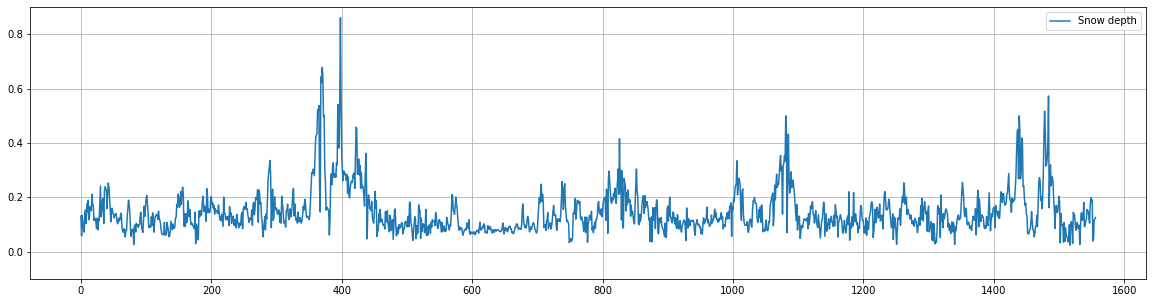

In [113]:
fig = plt.figure(figsize=(20,5))

plt.plot(mp_data["snowdepth"].values,label = "Snow depth")
plt.ylim(-0.1, 0.9)
plt.legend()
plt.grid()

In [114]:
printstats(mp_data["snowdepth"].values)

number of observations: 1557
min: 0.02382
max: 0.861
mean: 0.14467431599229286
median: 0.1231
standard deviation: 0.08224934809961033
skewness: 2.588834146757118


### Estimate surface and under-ice roughness

Collect a proxy for roughness - the standard deviation of elevation (and draft) within an approximate 5 m sliding window

In [115]:
## surface roughness. Because step size is about 0.8m, we use a window size of 6 - approx. 4.m along track

elevation_roughness = bn.move_std(elevation, window=6)


In [116]:
## draft roughness, same window size

draft_roughness = bn.move_std(drafts, window=6)

## Plot all the things together

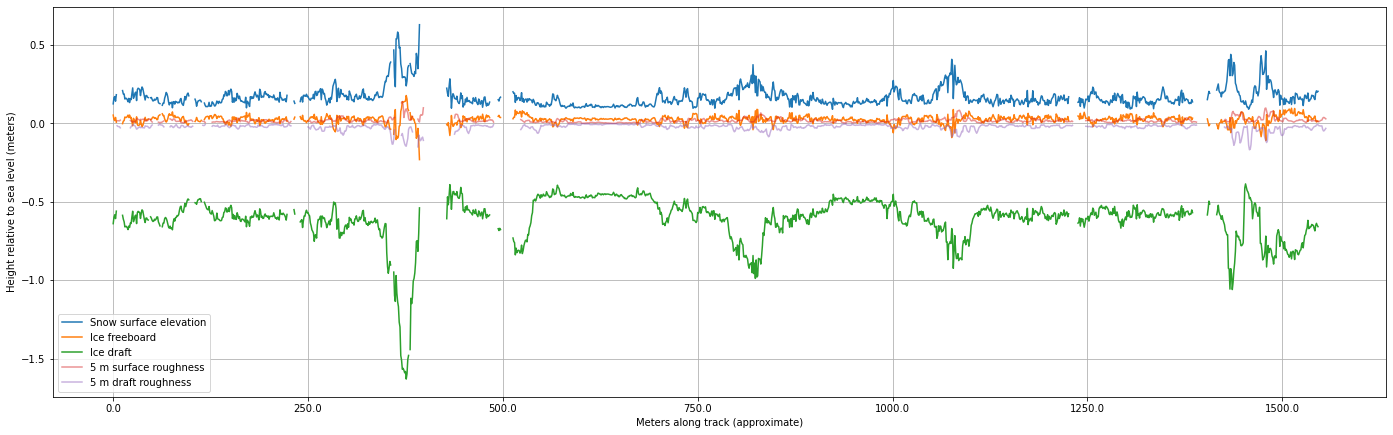

In [118]:
fig = plt.figure(figsize=(60/inches,18/inches))

plt.plot(freeboards[5:-5] + mp_data["snowdepth"].values[5:-5], label = "Snow surface elevation")
plt.plot(freeboards[5:-5], label = "Ice freeboard")
plt.plot(drafts[5:-5], label = "Ice draft")

## roughnesses are offset a little, just so they're visible
plt.plot(np.array(elevation_roughness), label = "5 m surface roughness", alpha = 0.5)

plt.plot((0-draft_roughness), label = "5 m draft roughness", alpha = 0.5)


plt.legend()

plt.grid()
ax = plt.gca()

thenumbers = np.arange(0, len(drafts),250)
xticks_meters = [x * np.median(mp_point2point) for x in thenumbers]

plt.xticks(thenumbers,xticks_meters)

ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax.set_xlabel("Meters along track (approximate)")
ax.set_ylabel("Height relative to sea level (meters)")

plt.savefig("/mnt/documents/Q1/P5-12032021/alongtrack-snowandice.png")


In [119]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

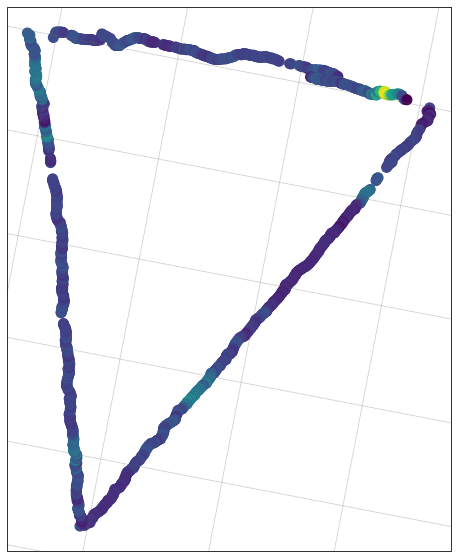

In [134]:
fig = plt.figure(figsize=(10,10))

mapproj = ccrs.NorthPolarStereo(central_longitude= -45 , true_scale_latitude = 70 )

ax = plt.axes(projection= mapproj)


plt.scatter(mp_data["easting"].values-5, mp_data["northing"].values, c=zi, s = 100,
           transform=ccrs.NorthPolarStereo(central_longitude= -45 , true_scale_latitude = 70 ))
#cbar = plt.colorbar()
#cbar.set_label("Ice thickness")
#gl = ax.gridlines(draw_labels=True)
#gl.top_labels = False
#gl.right_labels = False

showgridlines = ax.gridlines(color=[0.4, 0.4, 0.4, 0.3], draw_labels=True)


In [121]:
icebins = np.arange(0, np.nanmax(zi[5:-5]), 0.05)
snowbins = np.arange(0, 0.5, 0.005)

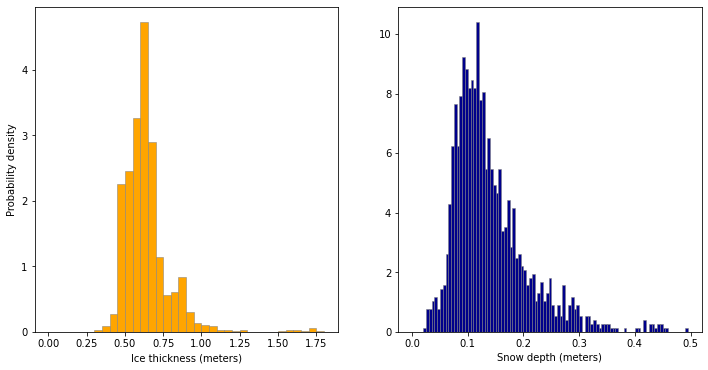

In [122]:
fig = plt.figure(figsize = (30/inches,15/inches))

ax1 = fig.add_subplot(121)

#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax2 = fig.add_subplot(122)
#ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

day1hist, icex, _ = ax1.hist(zi, icebins, linewidth=0.5, ec = 'gray',
                             facecolor='Orange', label = 'ice thickness',
                            density = True)


day1snowhist, snowx, _ = ax2.hist(mp_data["snowdepth"].values, snowbins,
                                linewidth=0.5, ec = 'gray', facecolor='DarkBlue',
                                label = 'snow depth', density = True)


ax1.set_xlabel("Ice thickness (meters)")
ax1.set_ylabel("Probability density")
ax2.set_xlabel("Snow depth (meters)")

plt.savefig("/mnt/documents/Q1/P4-10032021/AeNQ1-2021-P6-zi-zs-2panelhistogram.png")

(0.0, 10.0)

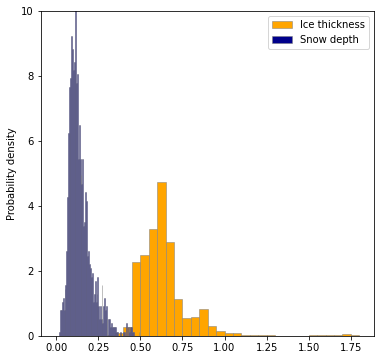

In [123]:
fig = plt.figure(figsize = (15/inches,15/inches))

ax1 = fig.add_subplot(111)

#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
#ax2 = fig.add_subplot(122)
#ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

day1hist, icex, _ = ax1.hist(zi[5:-5], icebins, linewidth=0.5, ec = 'gray',
                             facecolor='Orange', label = 'Ice thickness',
                             density = True)


day1snowhist, snowx, _ = ax1.hist(mp_data["snowdepth"].values, snowbins,
                                linewidth=0.5, ec = 'gray', facecolor='DarkBlue',
                                label = 'Snow depth', density = True)


#ax1.set_xlabel("GEM2 ice thickness (meters)")
ax1.set_ylabel("Probability density")
#ax2.set_xlabel("Magnaprobe snow depth (meters)")

plt.legend()

plt.savefig("/mnt/documents/Q1/P5-12032021/AeNQ1-2021-P5-zi-zs-onepanelhistogram.png")
plt.ylim(0,10)

In [124]:
fb_bins = np.arange(0, np.nanmax(freeboards), 0.005)
elevbins = np.arange(0, 1, 0.01)

Text(0.5, 0, 'Elevation')

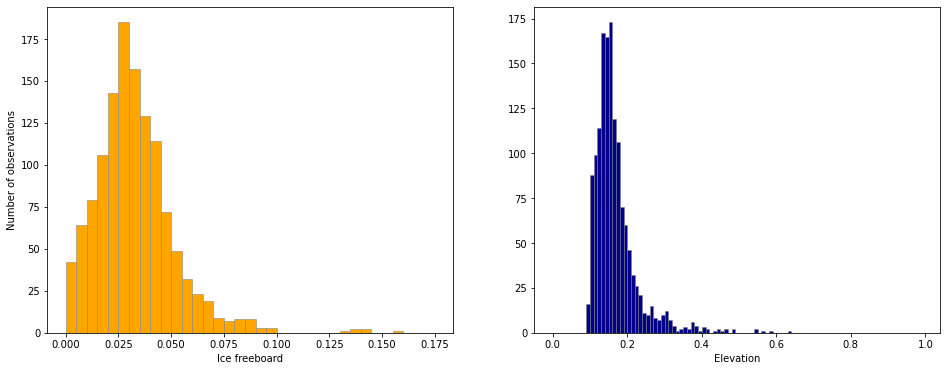

In [125]:
fig = plt.figure(figsize = (16,6))

ax1 = fig.add_subplot(121)

#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax2 = fig.add_subplot(122)
#ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

day1hist, icex, _ = ax1.hist(freeboards, fb_bins, linewidth=0.5, ec = 'gray',
                             facecolor='Orange', label = 'Freeboard')


day1snowhist, snowx, _ = ax2.hist(elevation, elevbins,
                                linewidth=0.5, ec = 'gray', facecolor='DarkBlue',
                                label = 'Elevation')


ax1.set_xlabel("Ice freeboard")
ax1.set_ylabel("Number of observations")
ax2.set_xlabel("Elevation")

In [126]:
elev_roughness_bins = np.arange(0, np.nanmax(elevation_roughness), 0.005)
draft_roughness_bins = np.arange(0, np.nanmax(draft_roughness), 0.005)


Text(0.5, 0, 'Draft roughness')

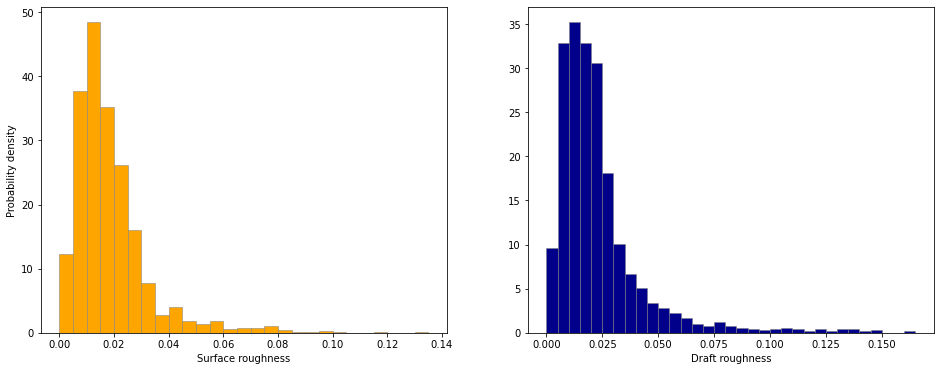

In [127]:
fig = plt.figure(figsize = (16,6))

ax1 = fig.add_subplot(121)

#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax2 = fig.add_subplot(122)
#ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

day1hist, icex, _ = ax1.hist(elevation_roughness, elev_roughness_bins, 
                             density = True,
                             linewidth=0.5, ec = 'gray',
                             facecolor='Orange', label = '5 m surface roughness')


day1snowhist, snowx, _ = ax2.hist(draft_roughness, draft_roughness_bins,
                                density = True,
                                linewidth=0.5, ec = 'gray', facecolor='DarkBlue',
                                label = '5 m draft roughness')


ax1.set_xlabel("Surface roughness")
ax1.set_ylabel("Probability density")
ax2.set_xlabel("Draft roughness")

Text(0, 0.5, 'surface elevation')

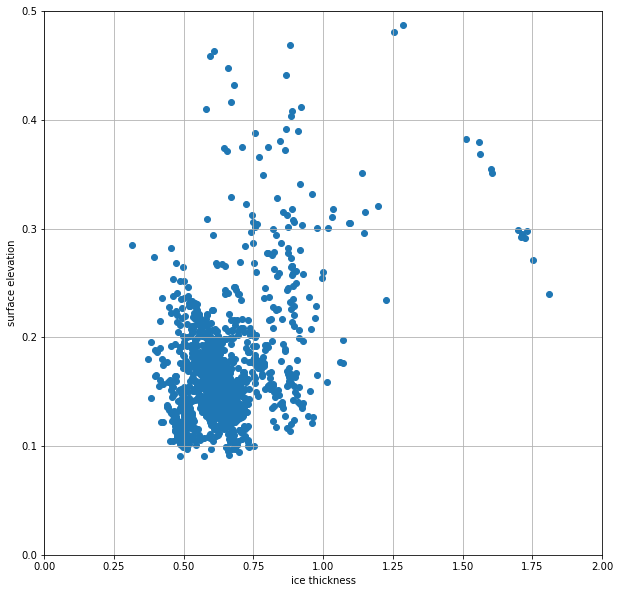

In [129]:
fig = plt.figure(figsize=(10,10))
plt.scatter(zi, elevation)
plt.xlim(0, 2)
plt.ylim(0, 0.5)
plt.grid()
plt.xlabel("ice thickness")
plt.ylabel("surface elevation")


In [130]:
# from: https://localcoder.org/pearson-correlation-and-nan-values

bad = ~np.logical_or(np.isnan(elevation), np.isnan(zi))

elevs_for_r = np.compress(bad, elevation)
zi_for_r = np.compress(bad, zi)

In [131]:
stats.spearmanr(elevation, zi, nan_policy = "omit")

SpearmanrResult(correlation=0.2822141487371199, pvalue=1.8276075379596364e-27)

## Some main core site stats

In [4]:
maincore = pd.read_csv("/mnt/documents/Q1/P5-12032021/, skiprows=5)

In [6]:
maincore[0:2]

Prio #core Core name Responsoble  core length (cm)  ice thickness (cm)  \
0   2.0     1      PP 1       Marti              57.0                57.0   
1   2.0     2      PP 2       Marti              53.0                53.0   

   ice-water distance (cm)  freeboard (cm)  snow depth 1 (cm)  \
0                     56.0             1.0               18.0   
1                     52.0             1.0               15.0   

   snow depth 2 (cm)  ...               COMMENT Section (cm) Section horizons  \
0               18.0  ...  4 cm offset included         0-30              0-1   
1               11.5  ...  4 cm offset included         0-30              0-1   

  Pooling FSW?/Processing                                          Parameter  \
0     1.2             NaN  primary productivity and 15N uptake, bacterial...   
1     1.2             NaN                                                NaN   

          Requested by                                     Remarks DARK?  \
0  Oliver, Marti, Rolf  Sectionned, sterile bagged, taken on board   yes   
1  Oliver, Marti, Rolf  Sectionned, sterile bagged, taken on board   yes   

                   comment  
0  needs to be taken first  
1  needs to be taken first  

[2 rows x 21 columns]

In [7]:
snow1 = []
for x in maincore["snow depth 1 (cm)"]:
    try:
        snow1.append(float(x))
    except:
        pass
    

for x in maincore["snow depth 2 (cm)"]:
    try:
        snow1.append(float(x))
    except:
        pass
    
for x in maincore["snow depth 3 (cm)"]:
    try:
        snow1.append(float(x))
    except:
        pass

## map of ice thickness values

Visualising how many matches we got between MP and GEM2 data

In [135]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

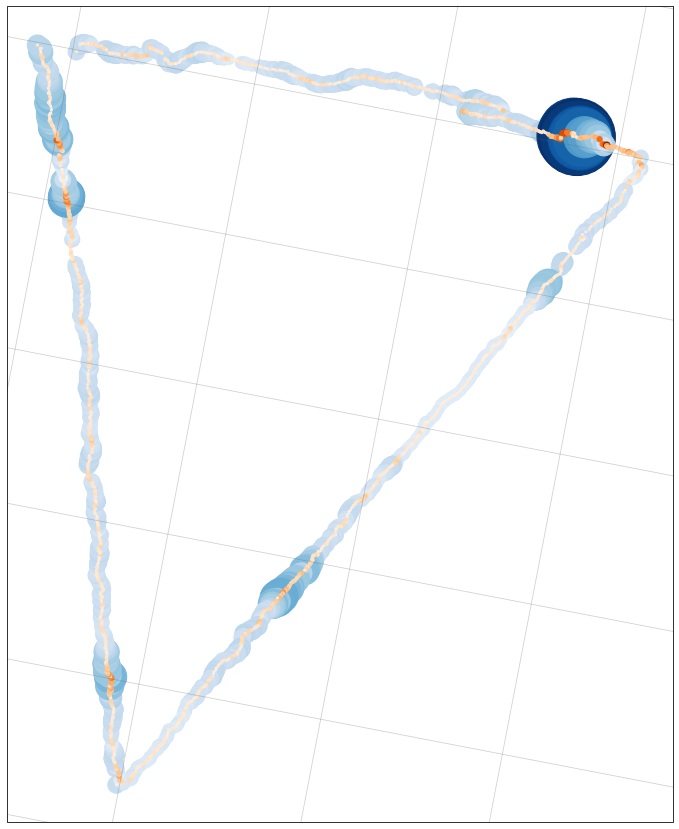

In [144]:
fig = plt.figure(figsize=(15,15))

mapproj = ccrs.NorthPolarStereo(central_longitude= -45 , true_scale_latitude = 70 )

ax = plt.axes(projection= mapproj)


plt.scatter(mp_data["easting"].values, mp_data["northing"].values, c=zi, s = (10*zi)**3,
           transform=ccrs.NorthPolarStereo(central_longitude= -45 , true_scale_latitude = 70 ),
           label = "Ice thickness", cmap="Blues")

#plt.scatter(mp_data["easting"].values, mp_data["northing"].values,
#           c=elevation, s = (5 * elevation)**4, cmap="viridis",
#           transform=ccrs.NorthPolarStereo(central_longitude= -45 , true_scale_latitude = 70 ),
#           label = "Ice thickness")


plt.scatter(mp_data["easting"].values, mp_data["northing"].values,
           c=mp_data["snowdepth"].values, s = (50*mp_data["snowdepth"].values), cmap="Oranges",
           transform=ccrs.NorthPolarStereo(central_longitude= -45 , true_scale_latitude = 70 ),
           label = "Ice thickness")
#cbar = plt.colorbar()
#cbar.set_label("Ice thickness")
#gl = ax.gridlines(draw_labels=True)
#gl.top_labels = False
#gl.right_labels = False

showgridlines = ax.gridlines(color=[0.4, 0.4, 0.4, 0.3], draw_labels=True)

plt.savefig("")

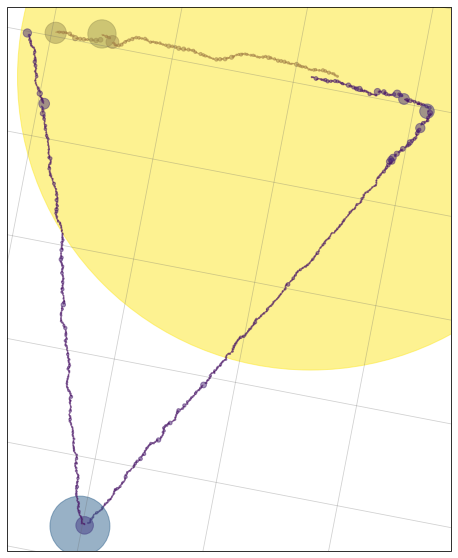

In [137]:
fig = plt.figure(figsize=(10,10))

mapproj = ccrs.NorthPolarStereo(central_longitude= -45 , true_scale_latitude = 70 )

ax = plt.axes(projection= mapproj)


plt.scatter(mp_data["easting"].values[1:], mp_data["northing"].values[1:], c= mp_point2point, s= mp_point2point**4, alpha=0.5,
           transform=ccrs.NorthPolarStereo(central_longitude= -45 , true_scale_latitude = 70 ))
#cbar = plt.colorbar()
#cbar.set_label("Ice thickness")
#gl = ax.gridlines(draw_labels=True)
#gl.top_labels = False
#gl.right_labels = False

showgridlines = ax.gridlines(color=[0.4, 0.4, 0.4, 0.3], draw_labels=True, x_inline = False)

## Export ice thickness data to a CSV file

In [71]:
backtolatlon = pyproj.transformer.Transformer.from_proj(3413,4326)
latlon = backtolatlon.transform( mp_data["northing"].values,mp_data["easting"].values,)

In [72]:
zi_export = pd.DataFrame({"timestamp": mp_data["timestamp"].values,
                          "easting": mp_data["easting"].values,
                          "northing": mp_data["northing"].values,
                          "latitude": latlon[0],
                          "longitude": latlon[1],
                          "snowdepth": mp_data["snowdepth"].values,
                          "ice_freeboard": freeboards,
                          "ice_thickness": zi,
                          "surface_elevation": elevation,
                          "ice_draft": drafts,
                          "5m_surface_roughness": elevation_roughness,
                          "5m_draft_roughness": draft_roughness})

In [73]:
header = """
Snow depth and ice thickness data from AeN Q1, P4
March 2021
Adam Steer, Dmitry Divine
GEM2 data processed using libraries supplied by Stefan Hendricks
Drift correction and data alignment here: https://gitlab.com/adamsteer/aen/
Units are meters
Eastings and northings are EPSG:3413, NSIDC north polar stereographic



"""

In [74]:
outputfile = "/mnt/documents/Q1/P4-10032021/AenQ1-P4-snowandice.csv"

In [75]:
with open(outputfile, 'w') as outfile:
    outfile.write(header)
    
zi_export.to_csv(outputfile, index=False, mode='a')